In [121]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import c, k_B, M_sun, G, m_p, sigma_sb, m_p
import astropy.units as u
from scipy.integrate import solve_ivp
import numpy as np
import numba
import sys

sys.path.append('../Numerical_methods')
from matrix_calculator import A_matrix
from scheme_calculator import forward_backward
from bachelor_funcs import Σ_initial, r_array, get_1_dev_irr

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)

### Equation 10 from Suzuki

$$  \frac{\partial\Sigma}{\partial t} - \frac{1}{r}\frac{\partial}{\partial r}\left[
    \frac{2}{r\Omega}\left\{
    \frac{\partial}{\partial r}\left(
    r^2\Sigma\alpha_{r\phi}c_s^2
    \right)
    + r^2\alpha_{\phi z}(\rho c_s^2)_{\textrm{mid}}
    \right\}\right]
    + C_{\textrm{w}}(\rho c_s)_{\textrm{mid}}
    \;=\;0$$

$$
\Omega\approx\Omega_K=\sqrt{\frac{GM_*}{r^3}}
$$    

$$
c_s^2=\frac{k_BT}{\mu m_H}
$$

#### Neglecting disc wind and torque:
$$  \frac{\partial\Sigma}{\partial t} - \frac{1}{r}\frac{\partial}{\partial r}\left[
    \frac{2}{r\Omega}\left\{
    \frac{\partial}{\partial r}\left(
    r^2\Sigma\alpha_{r\phi}c_s^2
    \right)
    \right\}\right]
    
    \;=\;0$$

#### From B.10:
$$\sigma_\textrm{SB}T^4=\frac{3}{4}\Omega\Sigma\bar{\alpha_{r\phi}}c_s^2$$

$$\Rightarrow \quad c_s^6\;=\;\frac{1}{\sigma_\textrm{SB}}
\left(\frac{\mu m_{H}}{K_B}\right)^{-4}
\frac{3}{4}\Omega\Sigma \bar{\alpha_{r\phi}}
$$

In [122]:
μ = 2.34    #(Hayashi 1981)

In [123]:
def Omega_kep(r):
    return np.sqrt((G * M_sun) / r**3)


def c_s(Ω,  Σ, α_rφ = 8e-3):
    return ((sigma_sb**(-1) * (μ * m_p / k_B)**(-4) * 3/4 * Ω * Σ * α_rφ)**(1/6)).to('m/s')

In [124]:
r = r_array * u.au
c_s(Omega_kep(r), Σ_initial(r))[0]

<Quantity 9063.54972517 m / s>

### Imposing the boundary condition $\frac{\partial}{\partial r}(\Sigma r^{3/2})=0$

$$\frac{\partial}{\partial r}(\Sigma r^{3/2})=0$$
$$\Rightarrow\frac{\partial}{\partial r}(\Sigma)\cdot r^{3/2}\;+\;\frac{3}{2}\Sigma r^{1/2}=0$$
$$\Sigma r^{2}=-\frac{2}{3}\;r^{3}\;\frac{\partial}{\partial r}\Sigma$$


In [125]:
α_rφ = 8e-3


def one_alpha_diff(Σ):
    boundary = -2/3 * r**(3) * get_1_dev_irr(Σ)
    
    inner_1 = Σ * r**(2)
    #inner_1[0] = boundary[0]
    #inner_1[-1] = boundary[-1]

    inner_2 = α_rφ * c_s(Omega_kep(r), Σ)**2

    inner_dev = get_1_dev_irr(inner_1 * inner_2)
    
    outer_dev = get_1_dev_irr(2 / (r *Omega_kep(r)) * inner_dev)

    #outer_dev[0] = 0
    #outer_dev[-1] = 0

    return ((r**(-1) * outer_dev * u.au**(-2)).to('mg/(yr * cm^2)'))

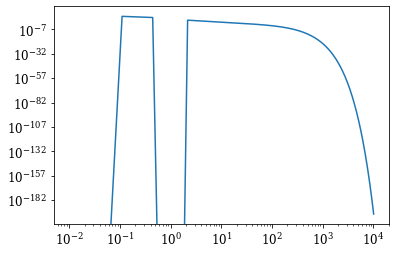

In [126]:
plt.loglog(r_array, one_alpha_diff(Σ_initial(r)))



In [127]:
α_rφ = 8e-3
def one_alpha_diff(t, Σ):
    if isinstance(Σ, np.ndarray):
        Σ = Σ *  u.g * u.cm**-2
    boundary = -2/3 * r**(3) * get_1_dev_irr(Σ)
    
    inner_1 = Σ * r**(2)
    #inner_1[0] = boundary[0]
    #inner_1[-1] = boundary[-1]

    inner_2 = α_rφ * c_s(Omega_kep(r), Σ)**2

    inner_dev = get_1_dev_irr(inner_1 * inner_2)
    
    outer_dev = get_1_dev_irr(2 / (r *Omega_kep(r)) * inner_dev)

    #outer_dev[0] = 0
    #outer_dev[-1] = 0

    return ((r**(-1) * outer_dev * u.au**(-2)).to('mg/(yr * cm^2)'))

#### "one_alpha_diff" return in terms of:
$$\left[\frac{g}{cm^2}\frac{1}{kyr}\right]$$

In [149]:
# Default values for tolerance:
# rtol: 1e-3 
# atol: 1e-6 

times = np.arange(1000)
sol = solve_ivp(one_alpha_diff, [times[0], times[-1]], y0 = Σ_initial(r), t_eval = times, method = 'LSODA', rtol = 0.2 , atol = 100)
sol

  message: 'Unexpected istate in LSODA.'
     nfev: 3
     njev: 0
      nlu: 0
      sol: None
   status: -1
  success: False
        t: array([0, 1])
 t_events: None
        y: array([[nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
    

(205, 1)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18